# Working with text

In this problem, we will load movie reviews from IMDB, a famous movie database and website, and we will try to predict whether the review is positive or negative.

First, the function we will use to diagnose the performance of our model

In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Input data

In [3]:
from keras.datasets import imdb

Using TensorFlow backend.


In [0]:
# Run this to download the data prior to the lecture
# Los textos de los user reviews son la entrada. La salida son las estrellas de
# la gente
train, test = imdb.load_data(num_words=10000)

In [6]:
type(train)

tuple

Why are these *texts* numbers?

In [7]:
train[1].shape

(25000,)

In [8]:
train[0].shape

(25000,)

In [0]:
train_text, train_labels = train
test_text, test_labels = test



In [10]:
train_text[4][0:10]

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637]

In [11]:
train_labels[4]

0

In [0]:
# estos indices son una lookuptable del diccionario de las palabras

In [0]:
word_index = imdb.get_word_index()

In [15]:
[word_index[i] for i in ['car', 'phone']]

[516, 1696]

These are actually indices in a word index

In [0]:
reversed_word_index = dict((value, key) for (key, value) in word_index.items())

In [0]:
def get_text_from_vector(v):
    return ' '.join(reversed_word_index.get(i-3, '?') for i in v)

In [18]:
get_text_from_vector(train_text[4][0:10])

'? worst mistake of my life br br i picked'

### Prepare data for the network

We need to prepare the data to be an input to the neural network. The input must be a **tensor**. In our case, all vectors should be of the same length. But not all reviews are of the same size, so the vectors will have different sizes. How can we overcome this problem?

* We can zero-pad the vectors, so all of them have the same size, and then combine them in a tensor. We would need to add an *Embedding* layer to learn **word embeddings** (more later)
* Or we can use 1-HOT encoding

In both cases, we will have vectors of size $10^4$ (the maximum number of words). Let's go with the 1-HOT encoding.

In [0]:
from keras.preprocessing import text
# Las sequencias son listas en las que el orden importa, como series temporales.

In [22]:
train_text.shape

(25000,)

In [24]:
type(train_text)

numpy.ndarray

In [25]:
len(train_text[2])

141

In [27]:
len(train_text[3])

550

In [0]:
# la lngitud es el numero de palabras que tiene esa review. Necesitamos que todas
# las reviews tengan el mismo numero de palabras

In [0]:
text.Tokenizer.sequences_to_matrix 
tokenizer = text.Tokenizer(num_words=10000)
# con esto le decimos las palabras máximas que puede tener un tokenizador

In [0]:
# Los tokenizadores te debiden algo en unidades mas pequeñas. Por ejemplo, frases en palabras.
# o verbos a su raiz, o palabras a su raiz (eliminando el genero)

train_text_m = tokenizer.sequences_to_matrix (train_text, mode='binary')
# el modo binario es one hot encoding

In [34]:
train_text_m.shape

(25000, 10000)

In [35]:
# cada fila es un review, cada columna es un one hot encoding, con 0 si no 
# aparece y 1 si aparece

train_text_m[0][0:25]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0.])

In [0]:
# con este enfoque, no sabes la repetición de las palabras, solo si existen o no
# existe. Al igual que el orden

In [37]:
train_labels.shape

(25000,)

In [39]:
type(train_labels)

numpy.ndarray

In [0]:
# no hay que transformar las etiquetas porque las dimensiones encajan y ademas ya son valores binarios de review positiva o negativa

In [0]:
# LAs mismas aplicaciones aplicadas al conjunto de training se aplican al de text
test_text_m = tokenizer.sequences_to_matrix (test_text, mode='binary')

In [0]:
# no hacemos feature engineer, solo transformamos los datos para que encajen en la red


**EXERCISE 1**. Can you see any problem with this approach? How would you solve it?

**EXERCISE 2**. Do we need to transform the labels? Why? Or why not?

## Let's build the model

In [0]:
from keras import models, layers

In [0]:
# Recordar que hay que pasar una tupla a la red
# Hay que ir reduciendo las dimensiones de las capas porque la salida es sólo un número
m1hot = models.Sequential()
m1hot.add(layers.Dense(256, activation='relu', input_shape=(10000,)))
m1hot.add(layers.Dense(128, activation='relu'))
m1hot.add(layers.Dense(64, activation='relu'))
# En la salida la función de activación es muy importante, dado que en este caso
# debe estár acotada entre 0 y 1, dado que lo queremos predecir es un valor binario
# Es bueno que la función de activación esté relacionada con la de pérdidas. En este caso la distancia esta entre 0 y 1
m1hot.add(layers.Dense(1, activation='sigmoid'))


In [0]:
from keras import optimizers, losses, metrics
m1hot.compile(
optimizer=optimizers.rmsprop(),
loss=losses.categorical_crossentropy,
metrics=[metrics.binary_accuracy]
)

In [52]:
h = m1hot.fit(train_text_m, train_labels, epochs=20, batch_size=1024, validation_split=.2)

ValueError: ignored

In [0]:
m1hot.evaluate(test_text_m, test_labels,batch_size=1024)

# Analyze performance

We cannot find a satisfactory model with what we have learned so far. Is there any way to have a better representation of text that can provide better results?

# Word embeddings

Using 1-HOT encoded vectors produce large and sparse tensors, that are difficult to learn from using a neural network. Word embeddings are compact vectors, representing words in a vector space. These vectors are learnt in a neural network, with a layer of type *Embedding*. We can also even use pre-trained word embeddings, to improve our model

![](./imgs/07_embeddings.png)

To generate  an embedding, we need to tokenize the text, transforming words into indices, and then we use these lists of numbers to produce the vectorial representation:

![](./imgs/08_embeddings.png)

More info:
* http://www.offconvex.org/2015/12/12/word-embeddings-1/
* http://www.offconvex.org/2016/02/14/word-embeddings-2/

## Input data for word embeddings

In [0]:
# rey - reina = principe - princesa
# rey + mujer = reina
# hay tipos de relaciones que se capturan en los embeddings que podemos aprovechar
# se captura tanto la secuencia como la semantica. 

# Igual que hay embedings de palabras, hay embeddings de cualquier cosa. Por ejemplo,
# el client to vec, que transforma las propiedades de un cliente a vectores.

## Let's build the model with embeddings

In [53]:
train_text.shape

(25000,)

In [54]:
train_labels.shape

(25000,)

In [0]:
# Se va a decidir un tamaño máximo de los reviews. Los reviews mas cortos los populamos 
# con zeros y los mas largos los truncamos.

# mapear cosas que no existen a zeros es una decisión arbitraria que puede afectar
# a la predicción

max_len = 100 # los acotamos a 100 xq estos modelos son mas complejos y tarda mas
embedding_dim = 32
max_word = 1000

In [0]:
from keras.preprocessing import sequence

train_text_p = sequence.pad_sequences(train_text, maxlen=max_len)

In [0]:
test_text_p = sequence.pad_sequences(test_text, maxlen=max_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
dense_13 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dense_14 (Dense)             (None, None, 16)          528       
_________________________________________________________________
dense_15 (Dense)             (None, None, 1)           17        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
# cada 100 palabras se va a convertir en un vector de 32 dimensiones


In [0]:
tra

In [0]:
# las capas densas son multiplicaciones de matrices, pero no tiene capacidad de estado ni de orden en el que llegan los ejemplos
# las redes recurrentes si tienen esa memoria y son capaces de modelar la secuencia. Su memoria es corta (adjetivo/nombre) las captura
# pero no mucho mas (por ejemplo parrafos)

m2emb = models.Sequential()
m2emb.add(layers.Embedding(max_len, embedding_dim))
m2emb.add(layers.SimpleRNN(32, return_sequences=True))
m2emb.add(layers.SimpleRNN(16, return_sequences=True))
m2emb.add(layers.SimpleRNN(8)) # con esto retorna un numero, no una secuencia
m2emb.add(layers.Dense(1, activation='sigmoid'))

In [0]:
m2emb.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.binary_crossentropy,
  metrics=[metrics.binary_accuracy]
)

In [83]:

m2emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          3200      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 16)          784       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


In [84]:
h = m2emb.fit(train_text_p, train_labels, epochs=20, batch_size=1024, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 229us/step - loss: 6.4548 - binary_accuracy: 0.1034 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
20000/20000 [==============================] - 4s 194us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 3/20
20000/20000 [==============================] - 4s 194us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 4/20
20000/20000 [==============================] - 4s 196us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 5/20
20000/20000 [==============================] - 4s 197us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 6/20
20000/20000 [==============================] - 4s 194us/step - loss: 7.9465 - binary_accuracy:

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


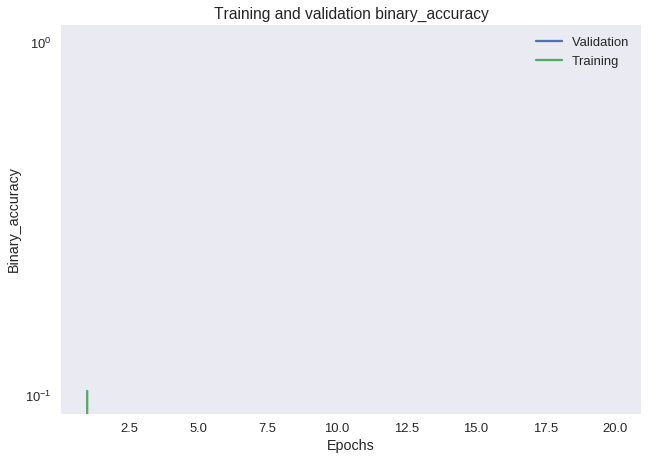

In [86]:
plot_metric(h,'binary_accuracy')

LSTM --> Es todo lo que necesitas !

Parece ser que funciona muy bien para muchas cosas

In [0]:
m2emb = models.Sequential()
m2emb.add(layers.Embedding(max_word, embedding_dim))
m2emb.add(layers.LSTM(32, return_sequences=True))
m2emb.add(layers.LSTM(16))
m2emb.add(layers.Dense(1, activation='sigmoid'))

In [106]:
m2emb.summary() # modelo mucho mas complejo que antes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 43,473
Trainable params: 43,473
Non-trainable params: 0
_________________________________________________________________


In [0]:
m2emb.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.binary_crossentropy,
  metrics=[metrics.binary_accuracy]
)

In [108]:
h = m2emb.fit(train_text_p, train_labels, epochs=10, batch_size=1024, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 593us/step - loss: 7.1885 - binary_accuracy: 0.0499 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
20000/20000 [==============================] - 10s 513us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 3/10
20000/20000 [==============================] - 10s 511us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 4/10
20000/20000 [==============================] - 10s 514us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 5/10
20000/20000 [==============================] - 10s 513us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 6/10
20000/20000 [==============================] - 10s 514us/step - loss: 7.9465 - binary_acc

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


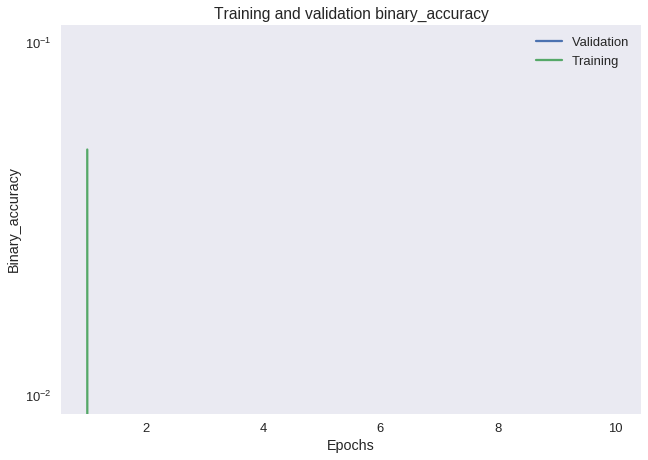

In [109]:
plot_metric(h,'binary_accuracy')

In [0]:
m2emb.evaluate(text_text_p, )

## Analyze performance

Not bad, with just an embedding layer, we get $75\%$ accuracy

How many reviews will be misclassified?

Let's check some of the predictions

In [0]:
N = 123
# N = 2344

So this prediction is correct. It says the review is negative. Let's have a look at the text:

In [0]:
get_text_from_vector(test_text[N])

"? if you believe that any given war movie can make you really feel the war you need to see called the ? are flying in english it tells the story of ? ? and boris who are in love on the verge of wwii they are walking along the ? watching the ? fly by when the war starts boris is promptly sent off to war ? hides out with a family and ends up marrying the son whom she does not love boris meanwhile continues ? through the countryside fighting the nazis and experiencing all the horrors of war until he he runs out of energy when ? working in a military hospital receives this news she refuses to accept it until ? body arrives home on one of the trains simultaneously the radio ? that germany has ? and the allied powers have won the war the soviet union lost 27 million citizens but it's the start of a new era br br this movie did a very good job showing the human impact of the war not only in the battlefield but also how it affected the ? population this is definitely a movie that everyone sho

Can we find all the reviews that are wrongly classified?

In [0]:
get_text_from_vector(test_text[3])

"? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision"

Is the classifier symmetric?

**EXERCISE** Can you construct the confusion matrix for this model? Can you calculate the precision and recall? How does it compare to accuracy?
* See https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

**EXERCISE (more complex)** Keras decided some time ago to remove precision, recall and F1-score from the list of available metrics. Was it a good decision? Why? Why did the Keras' authors did not remove accuracy too?
* https://github.com/keras-team/keras/issues/5794
* https://github.com/keras-team/keras/issues/4592

**EXERCISE** What is the ROC curve? Could you build the ROC curve for this model? How would you use a ROC curve to evaluate a classifier?
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* Help: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

Let's analyze wrong positives and wrong negatives separately. Then we will try to find a relationship between the words and the misclassification, both for false positives and negatives.

Now let's compare with the words of the true positives

So the most common words are very similar. Not surprising. Let's calculate the relative frequency of each word, and then find what are the words with the highest difference in relative frequency.

We see words such as *great*, *best*, *excellent*, which have a large difference between the true and the false positives. So false positives seem to lack some extreme words, and the classifier is having a hard time trying to assign a category to those reviews.